## DAY2 宿題
- Kickstarter Projectsの分類

◇ DAY_2の範囲でやったこと
- 外れ値除去
- 標準化
- K_Fold法による評価

◆ やってないこと
- カテゴリ変数を説明変数にする
　> これはやったほうがいい
- 正則化
　> K_Fold法の訓練正答率とテスト正答率を比べると
　　そこまで差が出ていなので少なくとも過学習はしていないと思います
- SVM
　> キックスターターが成功するかどうかは確率で予測したいので
　　ロジスティック回帰のままで進めます

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# DAY_1 4_linear_regression_multi_real_data
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# DAY_1 6_logistic_regression_real_data
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

# DAY_2 1_how_to_validation
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数

In [2]:
# DAY_3 5_descision_tree
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# https://qiita.com/Sasagawa0185/items/1185933dd0e560a26b07
import datetime

# 与えられた文字列型の時刻をdatetime型へ変換する関数
def str2datetime(t, format):
    return datetime.datetime.strptime(t, format)

# 差を秒に直したものを一日当たりの秒数でわったものを出力します
# 単位：日
def dateDiff(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/(60*60*24)

In [4]:
def standardize(df):
    return (df-df.mean())/df.std(ddof=True)
def normalize(df):
    return (df - df.min())/(df.max()-df.min())

### 1. データの読み込み

In [5]:
df_house = pd.read_csv("kickstarter-projects/ks-projects-201801.csv", index_col=0)
# 日付を期間に変換し列" dateDiff" に格納
df_house.launched = df_house.launched.apply(str2datetime, format='%Y-%m-%d %H:%M:%S')
df_house.deadline = df_house.deadline.apply(str2datetime, format='%Y-%m-%d')
df_house["dateDiff"] = df_house[["launched", "deadline"]].apply(dateDiff, axis=1)

# 連続量の特徴量（列名）
continuousCols = ["dateDiff", "goal"]

# 離散ラベルの特徴量
quantizedCols = ["category", "main_category", "currency", "country"]

# 固有の列
uniqueCols = ["name"]

# クラウドファウンディング前に利用できないと特徴量
unavailableCols = ["pledged", "backers", "usd pledged", "usd_pledged_real", "usd_goal_real"]


### 2. データの前処理

In [6]:
# 答えにするstate列を確認
df_house.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [7]:
# failed     -> 0
# successful -> 1
# canceled   -> 0
# others     -> delete
df_house = df_house[df_house.state != "undefined"]
df_house = df_house[df_house.state != "live"]
df_house = df_house[df_house.state != "suspended"]
df_house["stateValue"] = ("successful" == df_house["state"]).astype(float)

In [8]:
# カテゴリデータの確認
# ss_category = df_house.category
# ss_category.value_counts().count()
# -> 159 
# 多すぎる。似てるものを集めたら結局
# main_categoryと相関が高くなるはずなので今回はmain_categoryのみを採用

In [9]:
ss_category = df_house.main_category
ss_category.value_counts()
# データ量にばらつきはあるが、
# main_categoryはこのままやってみる

Film & Video    62282
Music           49254
Publishing      39047
Games           34723
Technology      31765
Design          29516
Art             27863
Food            24265
Fashion         22425
Theater         10850
Comics          10720
Photography     10675
Crafts           8661
Journalism       4672
Dance            3736
Name: main_category, dtype: int64

In [10]:
# country と currency について確認した感じ
# 相関がかなり高いのでcountryを採用し、
# USに偏っているので、USかそれ以外かで分ける
df_house.loc[df_house.country != "US", "country"] = "OTHER"
df_house.country.value_counts()

US       289671
OTHER     80783
Name: country, dtype: int64

In [11]:
requiredCols = ["stateValue", "dateDiff", "goal", "country", "main_category"]
df_dataset = df_house[requiredCols]
# 欠損値を確認
df_dataset.isnull().sum()

stateValue       0
dateDiff         0
goal             0
country          0
main_category    0
dtype: int64

In [12]:
# カテゴリ変数をone-hotに変換
df_tmp = pd.get_dummies(df_dataset, drop_first=True, columns=["country"])
df_dataset = pd.get_dummies(df_tmp, columns=["main_category"])
df_dataset.head()

,stateValue,dateDiff,goal,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
ID,,,,,,,,,,,,,,,,,,,
1000002330,0.0,58.491343,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1000003930,0.0,59.802813,30000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1000004038,0.0,44.985532,45000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1000007540,0.0,29.858206,5000.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1000011046,0.0,55.642326,19500.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
# 要約統計量の表示
df_dataset.describe()

,stateValue,dateDiff,goal,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,370454.000000,370454.000000,3.704540e+05,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000,370454.000000
mean,0.361600,33.840772,4.864199e+04,0.781935,0.075213,0.028937,0.023379,0.010085,0.079675,0.060534,0.168123,0.065501,0.093731,0.012612,0.132956,0.028816,0.105403,0.085746,0.029288
std,0.480464,60.693305,1.159868e+06,0.412932,0.263735,0.167631,0.151106,0.099916,0.270790,0.238474,0.373976,0.247408,0.291454,0.111591,0.339527,0.167289,0.307073,0.279989,0.168614
min,0.000000,0.005058,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.096586,2.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.683941,5.500000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,36.320104,1.630000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,14866.958333,1.000000e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# 期間（dateDiff）が[長すぎる／短すぎる]データがあるので、
# ひとまず期間が[1年以内／一週間以上]のプロジェクトという条件を追加する
df_dataset = df_dataset[df_dataset.dateDiff < 366]
df_dataset = df_dataset[df_dataset.dateDiff >= 7]
df_dataset.describe()

,stateValue,dateDiff,goal,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,367212.000000,367212.000000,3.672120e+05,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000,367212.000000
mean,0.361009,33.852654,4.839454e+04,0.782080,0.074652,0.028970,0.023273,0.010087,0.079878,0.060548,0.168279,0.065540,0.093646,0.012500,0.133147,0.028567,0.105519,0.086097,0.029299
std,0.480294,12.566364,1.148294e+06,0.412834,0.262829,0.167721,0.150768,0.099925,0.271104,0.238500,0.374114,0.247476,0.291336,0.111101,0.339733,0.166585,0.307222,0.280508,0.168644
min,0.000000,7.001424,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.105972,2.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.704149,5.500000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,36.804042,1.700000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,91.962650,1.000000e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# goalはどの範囲が確からしいか判断できなかったが、
# 100ドル以上, 1,000,000ドル未満という条件でデータセットを構築した
df_dataset = df_dataset[df_dataset.goal <= 1000000]
df_dataset = df_dataset[df_dataset.goal >= 100]
df_dataset.describe()

,stateValue,dateDiff,goal,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000
mean,0.360325,33.872928,22179.195805,0.783346,0.073934,0.028899,0.023074,0.010172,0.080331,0.060967,0.168536,0.063663,0.093627,0.012465,0.133979,0.028607,0.106109,0.086129,0.029506
std,0.480095,12.543517,66025.380438,0.411965,0.261664,0.167524,0.150138,0.100343,0.271806,0.239269,0.374342,0.244152,0.291310,0.110951,0.340631,0.166699,0.307978,0.280555,0.169221
min,0.000000,7.001424,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.107407,2000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.707685,5500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,36.862378,17000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,91.962650,1000000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# 標準化 dateDiff と goal のみ
df_dataset[requiredCols[1:3]] = df_dataset[requiredCols[1:3]].apply(standardize)
df_dataset.describe()

,stateValue,dateDiff,goal,country_US,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,362362.000000,3.623620e+05,3.623620e+05,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000,362362.000000
mean,0.360325,-4.585147e-14,6.106346e-17,0.783346,0.073934,0.028899,0.023074,0.010172,0.080331,0.060967,0.168536,0.063663,0.093627,0.012465,0.133979,0.028607,0.106109,0.086129,0.029506
std,0.480095,1.000000e+00,1.000000e+00,0.411965,0.261664,0.167524,0.150138,0.100343,0.271806,0.239269,0.374342,0.244152,0.291310,0.110951,0.340631,0.166699,0.307978,0.280555,0.169221
min,0.000000,-2.142262e+00,-3.344047e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-3.799190e-01,-3.056279e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-3.320634e-01,-2.526179e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.383263e-01,-7.844250e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,4.631055e+00,1.480977e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. データ統計量の確認

In [ ]:
# # 【重い】散布図行列を書いてみる
# pd.plotting.scatter_matrix(df_dataset.head(1000), figsize=(10,10))
# plt.show()

In [17]:
# 相関係数を確認
df_dataset[df_dataset.columns[:4]].corr()

,stateValue,dateDiff,goal,country_US
stateValue,1.000000,-0.116871,-0.135813,0.062426
dateDiff,-0.116871,1.000000,0.088296,0.036958
goal,-0.135813,0.088296,1.000000,-0.050183
country_US,0.062426,0.036958,-0.050183,1.000000


### 4. 分類

In [ ]:
# y = df_dataset["stateValue"].values
# X = df_dataset.drop("stateValue", axis=1).values
# n_split = 5 # グループ数を設定（今回は5分割）

# cross_valid_accuracy = 0
# split_num = 1

# # テスト役を交代させながら学習と評価を繰り返す
# for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
#     X_train, y_train = X[train_idx], y[train_idx] #学習用データ
#     X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
#     # 学習用データを使ってロジスティック回帰モデルを学習
#     clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
#     clf.fit(X_train, y_train)

#     # テストデータに対する予測を実行（比較用に訓練データに対する予測も行う）
#     y_est = clf.predict(X_test)
#     y_est_train = clf.predict(X_train)
    
#     print("Fold %s"%split_num)
    
#     #     # テストデータに対する対数尤度を表示
#     #     print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))
#     # 正答率を表示（カッコ内は訓練時の正答率）
#     accuracy = accuracy_score(y_test, y_est)
#     train_accuracy = accuracy_score(y_train, y_est_train)
#     print('正答率 = {:.3f}% ({:.3f}%)'.format(100 * accuracy, 100 * train_accuracy))    
#     # テストデータに対する予測と正解のクロス集計
#     conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
#                             index=['正解 = False, Canceled', '正解 = Success'], 
#                             columns=['予測 = False, Canceled', '予測 = Success'])
#     display(conf_mat)
#     print()
    
#     # 後で平均を取るために加算
#     cross_valid_accuracy += accuracy
#     split_num += 1

# # 正答率の平均値を最終的な汎化正答率とする
# final_accuracy = cross_valid_accuracy / n_split
# print("Cross Validation Accuracy = %.3f" % (final_accuracy*100))

In [51]:
y = df_dataset["stateValue"].values
X = df_dataset.drop("stateValue", axis=1).values

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

clf = DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_split=0.1, min_samples_leaf=3, random_state=1234)
# max_depth:6まで
clf = clf.fit(X_train, y_train)
print("score={:.3f}({:.3f})".format(clf.score(X_test, y_test), clf.score(X_train, y_train)))

score=0.652(0.651)


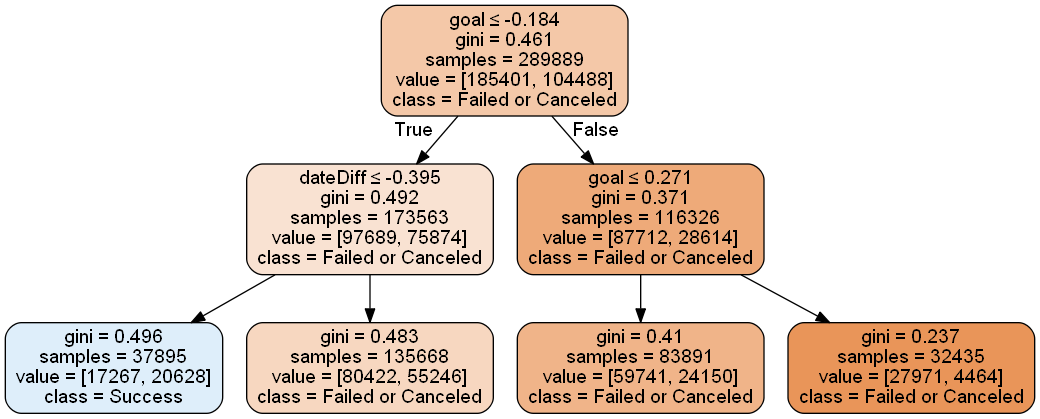

In [52]:
# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先

export_graphviz(clf, out_file=dot_data,  
                     feature_names=df_dataset.columns[1:],  
                     class_names=["Failed or Canceled","Success"],
                     filled=True, rounded=True,  
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [ ]:
df_dataset.columns[1:4]